,SalesReason,Occurrences,TotalRevenueUSD
0,Price,20580,4779212
1,On Promotion,3416,3227436
2,Manufacturer,972,3219460
3,Quality,835,2987855
4,Review,797,879312
5,Other,1624,113607
6,Television Advertisement,344,13314


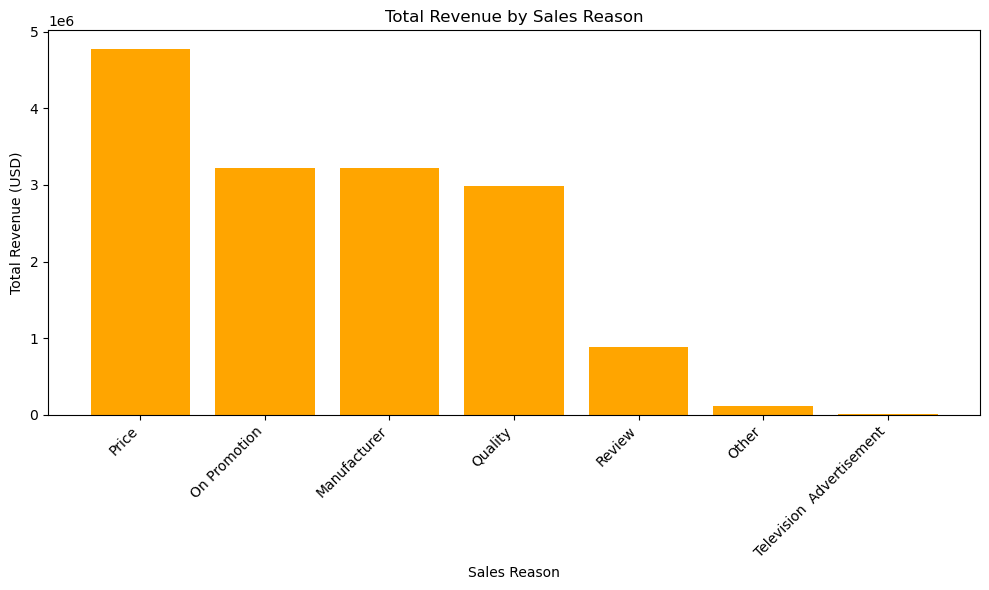

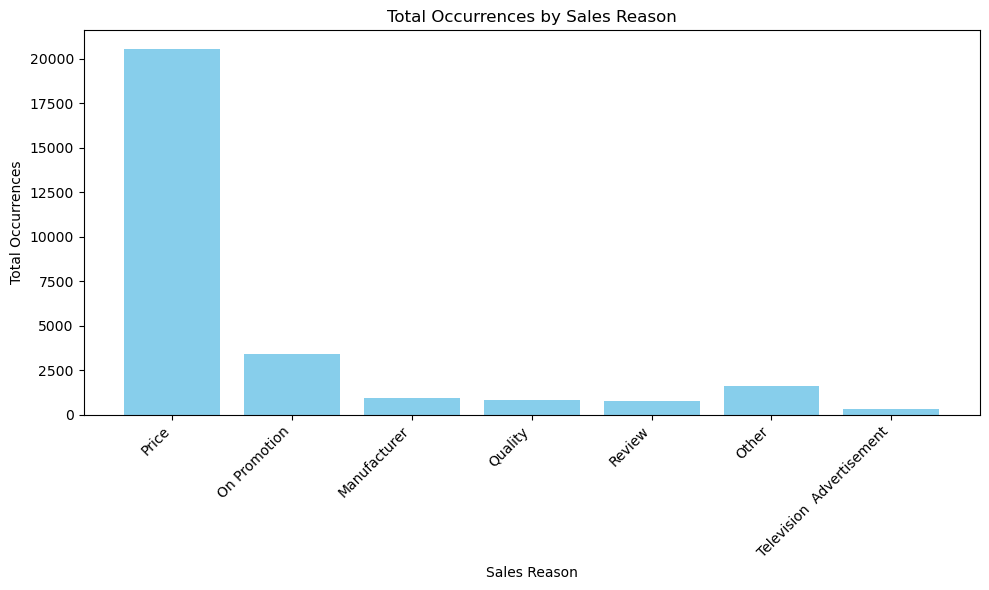

In [1]:
import matplotlib 
matplotlib.use("TkAgg")
%matplotlib inline
import pandas as pd
from sqlalchemy import create_engine
import pyodbc
import streamlit as st
import matplotlib.pyplot as plt
from IPython.display import display

if __name__ == '__main__':

    # Define your connection parameters
    server_name = 'IZAC'  # Replace with your server name
    database_name = 'AdventureWorks2022'  # Replace with your database name
    username = ''  # Replace with your username (if applicable)
    password = ''  # Replace with your password (if applicable)

    # Create the SQLAlchemy engine
    # Format for engine using pyodbc:
    # 'mssql+pyodbc://<username>:<password>@<dsn_name>'
    # DSN (Data Source Name) setup is optional, and you can connect without it directly
    if username and password:
        engine = create_engine(f'mssql+pyodbc://{username}:{password}@{server_name}/{database_name}?driver=SQL Server')
    else:
        engine = create_engine(f'mssql+pyodbc://{server_name}/{database_name}?driver=SQL Server&trusted_connection=yes')



    query = """SELECT sr.Name AS SalesReason,
       COUNT(sohsr.SalesOrderID) AS Occurrences,
       SUM(
           CASE 
               WHEN cr.FromCurrencyCode = 'USD' THEN sod.LineTotal
               ELSE sod.LineTotal * cr.EndOfDayRate
           END
       ) AS TotalRevenueUSD
FROM Sales.SalesReason sr
INNER JOIN Sales.SalesOrderHeaderSalesReason sohsr
    ON sr.SalesReasonID = sohsr.SalesReasonID
INNER JOIN Sales.SalesOrderHeader soh
    ON sohsr.SalesOrderID = soh.SalesOrderID
INNER JOIN Sales.CurrencyRate cr
    ON soh.CurrencyRateID = cr.CurrencyRateID
INNER JOIN Sales.SalesOrderDetail sod
    ON soh.SalesOrderID = sod.SalesOrderID
GROUP BY sr.Name
ORDER BY TotalRevenueUSD DESC; -- Or by Occurrences if needed

      
      """


    #query = "SELECT * FROM Sales.SalesOrderHeader"
    # Load query results into a DataFrame
    df = pd.read_sql(query, engine)


    df["TotalRevenueUSD"] = df["TotalRevenueUSD"].apply(lambda x: int(x + 0.5))

    df.style.background_gradient(cmap='coolwarm')

    display(df)

    
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    ax1.bar(df["SalesReason"], df["TotalRevenueUSD"], color="orange")
    ax1.set_xlabel("Sales Reason")
    ax1.set_ylabel("Total Revenue (USD)")
    ax1.set_title("Total Revenue by Sales Reason")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    plt.show()
    
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    ax2.bar(df["SalesReason"], df["Occurrences"], color="skyblue")
    ax2.set_xlabel("Sales Reason")
    ax2.set_ylabel("Total Occurrences")
    ax2.set_title("Total Occurrences by Sales Reason")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    plt.show()